# 1. Importing Libraries

In [1]:
import os
import pandas as pd
import torch
import torchvision

from typing import List
from torchvision.transforms import v2
from torchinfo import summary
from pathlib import Path

from modules.helper_functions import create_dataloaders, set_seeds, display_random_images, plot_loss_curves, save_model, load_model
from modules.engine import Trainer

NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 8
AMOUNT_TO_GET = 1.0
SEED = 42

# Define target data directory
#target_dir_name = f"../data/pizza_steak_sushi_applepie_hamburger_{str(int(AMOUNT_TO_GET*100))}_percent"
TARGET_DIR_NAME = f"../data/food-101_{str(int(AMOUNT_TO_GET*100))}_percent"

# Create target model directory
MODEL_DIR = Path("../models")

# Set seeds
set_seeds(SEED)

In [2]:
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# 2. Creating Dataloaders

In [3]:
# Create image size
IMG_SIZE = 480

manual_transforms = v2.Compose([    
    v2.Resize((IMG_SIZE, IMG_SIZE)),    
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    #v2.Normalize(mean=[0.485, 0.456, 0.406],
    #             std=[0.229, 0.224, 0.225]) 
])

manual_transforms_norm = v2.Compose([    
    v2.Resize((IMG_SIZE, IMG_SIZE)),    
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225]) 
])

manual_transforms_aug_norm_train = v2.Compose([    
    v2.TrivialAugmentWide(),
    v2.Resize((IMG_SIZE, IMG_SIZE)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.5, 0.5, 0.5],
                 std=[0.5, 0.5, 0.5]) 
])

manual_transforms_aug_norm_test = v2.Compose([        
    v2.Resize((IMG_SIZE, IMG_SIZE)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.5, 0.5, 0.5],
                 std=[0.5, 0.5, 0.5]) 
])

pretrained_resnetv2l_transforms = torchvision.models.EfficientNet_V2_L_Weights.DEFAULT.transforms()

In [4]:
print(f"Default EfficientNetV2-L transforms: {pretrained_resnetv2l_transforms}")

Default EfficientNetV2-L transforms: ImageClassification(
    crop_size=[480]
    resize_size=[480]
    mean=[0.5, 0.5, 0.5]
    std=[0.5, 0.5, 0.5]
    interpolation=InterpolationMode.BICUBIC
)


In [5]:
# Setup the directories
TARGET_DIR = Path(TARGET_DIR_NAME)
TRAIN_DIR = TARGET_DIR / "train"
TEST_DIR = TARGET_DIR / "test"

# Make the directories
TARGET_DIR.mkdir(parents=True, exist_ok=True)

# Create data loaders
train_dataloader_v2l, test_dataloader_v2l, class_names = create_dataloaders(
    train_dir=TRAIN_DIR,
    test_dir=TEST_DIR,
    train_transform=manual_transforms_aug_norm_train,
    test_transform=manual_transforms_aug_norm_test,
    batch_size=BATCH_SIZE
)

# 4. EfficientNet V2 L

In [6]:
# Create an EfficientNet-V2-L Model
def create_effnetv2l(
        transfer_learning: bool=True,
        class_names: List[str]=None,
        seed: int=SEED,
        dropout: float=0.4,
        device: torch.device = "cuda" if torch.cuda.is_available() else "cpu"
        ):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to len(class_names)
        seed (int, optional): Random seed to seed model weights. Defaults to SEED.
        dropout (float, optional): Dropout rate. Defaults to 0.2.

    Returns:
        model (torch.nn.Module): EffNetB0 feature extractor model.
        transforms (torchvision.transforms): Image transforms.
    """
    # Create EffNetB0 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_V2_L_Weights.DEFAULT # .DEFAULT = best available weights
        
    # Load pretrained weights    
    model = torchvision.models.efficientnet_v2_l(weights=weights).to(device)

    # Freeze the base parameters
    for parameter in model.parameters():
        parameter.requires_grad = not(transfer_learning)

    # Set the seeds
    set_seeds(seed)

    # Get the length of class_names (one output unit for each class)
    output_shape = len(class_names)

    # Recreate the classifier layer and seed it to the target device
    model.classifier = torch.nn.Sequential(
        torch.nn.Dropout(p=dropout, inplace=True), 
        torch.nn.Linear(in_features=1280, 
                        out_features=output_shape, # same number of output units as our number of classes
                        bias=True))
        
    return model, weights

# Instantiate the model
effnetv2l_model, _ = create_effnetv2l(transfer_learning=False,
                                      class_names=class_names)

# Compile model
effnetv2l_model = torch.compile(effnetv2l_model, backend="aot_eager")


# And a summary
summary(effnetv2l_model,
        input_size=(BATCH_SIZE,3,IMG_SIZE, IMG_SIZE), # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\Lib\site-packages\onnxscript\converter.py:820: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\Lib\site-packages\onnxscript\converter.py:820: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
W0102 19:41:51.536000 27636 site-packages\torch\_dynamo\convert_frame.py:844] [9/8] torch._dynamo hit config.cache_size_limit (8)
W0102 19:41:51.536000 27636 site-packages\torch\_dynamo\convert_frame.py:844] [9/8]    function: 'forward' (c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\Lib\site-packages\torchvision\ops\stochastic_depth.py:61)
W0102 19:41:51.536000 27636 site-packages\torch\_dynamo\convert_frame.py:844] [

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
OptimizedModule (OptimizedModule)                                 [8, 3, 480, 480]     [8, 101]             --                   True
├─EfficientNet (_orig_mod)                                        [8, 3, 480, 480]     [8, 101]             --                   True
│    └─Sequential (features)                                      [8, 3, 480, 480]     [8, 1280, 15, 15]    --                   True
│    │    └─Conv2dNormActivation (0)                              [8, 3, 480, 480]     [8, 32, 240, 240]    928                  True
│    │    └─Sequential (1)                                        [8, 32, 240, 240]    [8, 32, 240, 240]    37,120               True
│    │    └─Sequential (2)                                        [8, 32, 240, 240]    [8, 64, 120, 120]    1,032,320            True
│    │    └─Sequential (3)                               

Epoch: 10 | train_loss: 0.9666 | train_acc: 0.9573 | fpr_at_recall: 0.0005 | train_time: 82m8s | test_loss: 1.0947 | test_acc: 0.9288 | fpr_at_recall: 0.0020 | test_time: 10m54s | lr: 0.0000034227


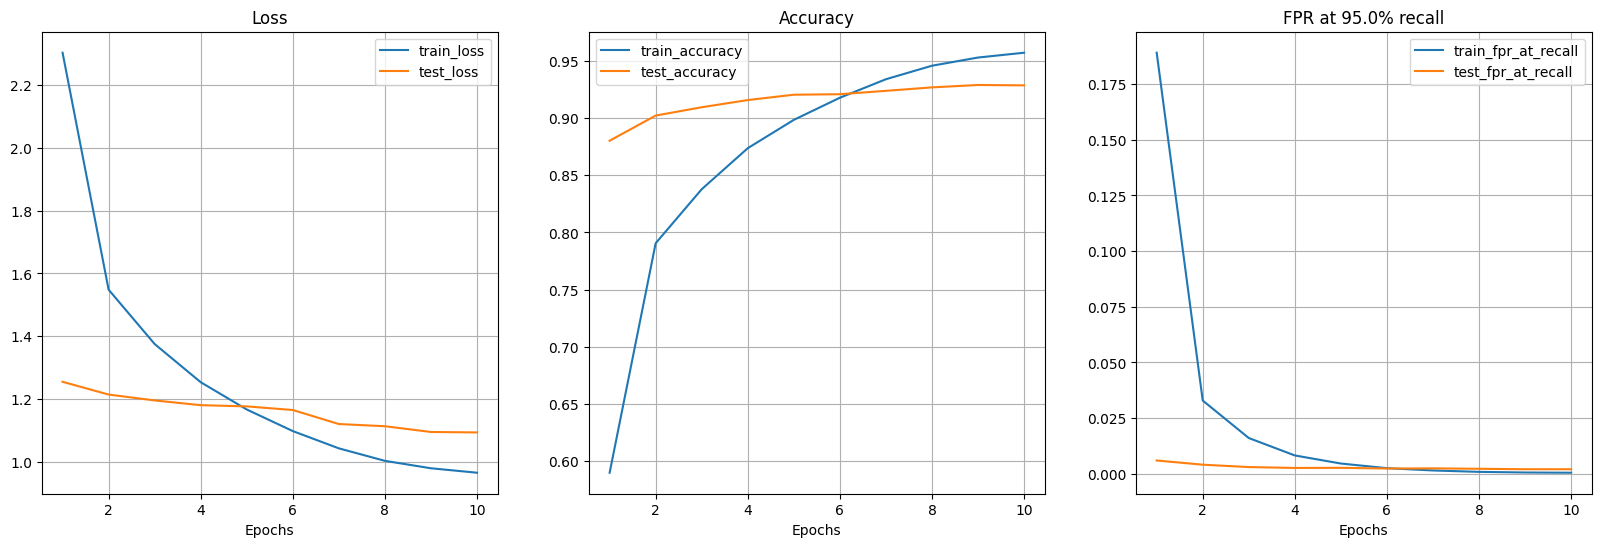

[INFO] Saving model to: ..\models\effnetv2l.pth


In [7]:
model_type="effnetv2l"
EPOCHS = 10
LR = 0.0001
model_name = f"{model_type}"
effnetv2l_model_name = model_name + ".pth"

# Create optimizer
optimizer = torch.optim.AdamW(params=effnetv2l_model.parameters(),
                            lr=LR,
                            betas=(0.9, 0.999),
                            weight_decay=0.01
)

# Create loss function
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

# Set scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

# Set seeds
set_seeds(SEED)

# And train...
train = Trainer(
    model=effnetv2l_model,
    save_best_model=True,
    mode="max", # Based on accuracy
    device=device)

vitbase16_1_results = train.fit(
    target_dir=MODEL_DIR,
    model_name=effnetv2l_model_name,
    train_dataloader=train_dataloader_v2l,
    test_dataloader=test_dataloader_v2l,
    optimizer=optimizer,
    loss_fn=loss_fn,
    recall_threshold=0.95,
    scheduler=scheduler,
    epochs=EPOCHS,
    amp=True,
    enable_clipping=False,
    debug_mode=False,
    accumulation_steps=8, # 8 batches of 8 images each per update
    early_stopping_patience=5
    )